In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")
sys.path.append("../es/")


import distance_utils
import random
import os
myseed = 13
random.seed(myseed)

import pandas as pd
from es.data.synthetic_data_cube import SyntheticDataCubeBuilder
import es.utils
import es.scorers
from es.experiments.distances import Distances

from bokeh.io import output_notebook
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q, df: sqldf(q, dict(tmp=df))

pd.set_option('display.max_rows', 40)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import seaborn as sns
# sns.set()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [11]:
# dist_code='inverse-log-tfidf'
# dist_code='inverse-tfidf'
dist_code='rank'
top_rank_count = 1 # 0 means that no additional products (beyond the huv0-3 winners will be added)
target="manual"
run='classic'
sample_orders = None
dist2force_funcs=["lambda x: (x)**-2"]
graph_iterations=[2000]

cube_size=3 # for GAIW
n_levels=2 # for GAIW
cand_size=5 # for GAIW / square side size - means cand_size^2 candidates
n_voters=1000 # for GAIW
search_terms = ['0_1c2$', '2_1c10$', '8_1c20$','1_1c2$', '3_1c10$', '4_1c20$','5_1c2$', '6_1c10$', '7_1c20$',]
layout_seed=13

# Movie distances

Goal: for two movies: a and b find a distance(a,b) in 0..1, the smaller the distance, the more similar the movies should be.

### distance as a metric (eg TFIDF) average
$dist$ = $dist^{TFIDF}(a,b) = \frac{TFIDF(a,b)+TFIDF(b,a)}{2}$

### distance as a metric (eg TFIDF) rank average
$dist$ = $dist_{rank}^{TFIDF}(a,b) = \frac{rank^{TFIDF}(a, b)+rank^{TFIDF}(b, a)}{2}$


## Process
- find a set S of movies to limit to
    - for a movie A: S = {A}
    - extend the set S with  { s results HUV 0, 1, 2, 3 | s in S }
    - extend the set S with { top tfidf results s | s in S }
- for a,b in SxS find dist(a,b)
- visualise S in 2D sticking to the dist
- run elections for various movies:
 - similar ones
 - different ones
 - visualise election results (to show distributions?)
- calc average metrics for HUV_x elections across all the movies in the set

## DB model

tables:
- winners - winners of the elections per search term/rule (HUV 0-3)
- product - id, product_name
- dist_metric - search_product_id	rank	product_id / where rank is the distance metric
- p2p_rank - search_title_1	found_title_2	id1	id2	rank_1_2	rank_2_1	avg_rank

## Calculate Distances

In [13]:
%%time

# PARAMS ==========================================

out_folder=f"../out/{target}/distances-synthetic/{run}"
if not os.path.exists(out_folder):
    os.mkdir(out_folder)
db_filename = f"{out_folder}/cache.db"
ds_key = 'synth'

# ==========================================

import numpy as np

metric_def_list = []

# bm_b_list=[round(x, 1) for x in np.linspace(0.0, 1.0, 11)]
# b in [0,1], b=1 means the document length is NOT taken into account
# k is proportional to the weight on TF (rather than IDF)
# metric_def_list+=[dict(kind='bm25', k=k, b=b) for k in np.linspace(25, 25, 1) for b in bm_b_list]

# tf_base_list=[round(x, 1) for x in np.linspace(1.2, 2.8, 5)]
tf_base_list = [1.85]
metric_def_list += [dict(kind='tfxtoidf', base=base) for base in tf_base_list]

k = 10
dataset = "synthetic"

n_candidates = np.power(cube_size**2, n_levels)*cand_size**2

PARAMS =  es.utils.dotdict(dict(
    exp_name='tmp',
    searchterms=search_terms, # for GAIW
    k=10,

    cube_size=cube_size,    
    n_levels=n_levels,
    n_voters=n_voters,
    n_candidates = n_candidates,
    cand_size=cand_size,
    n_approvals_per_voter=int(n_candidates * .08), # for GAIW: 2025*.08 = 162

    cube_proba=[.5, .1, .1, .1, .1, .025, .025, .025, .025], # for GAIW
    cand_weight_func=f"lambda x: -np.arctan((x-13)/10)+2", # cand ix proba density - for GAIW

    filtering=dict(sample_orders=sample_orders),
    rules=[f"HUV_i" for i in range(4)], 

    anneal_settings= {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}, # for GAIW
    scorer_metrics=['tfidfto2'],
    scorer_funcs = [es.scorers.AgentSpreadScoringStrategy.from_found_df_sorted_nosearchterm]
))

es.utils.log_experiment(out_folder, PARAMS)

metric_def = metric_def_list[0]
dataset_idata, dataset_iframes = SyntheticDataCubeBuilder.from_params(PARAMS, seed=13)
dataset_utils = es.electionutils.ElectionUtils(dataset_iframes, db_filename=db_filename)
db = dataset_utils.db

distances = Distances(dataset_utils, dist_code=dist_code)

distances.find_distances(
    metric_def=metric_def,
    titleREs=PARAMS.searchterms,
    top_rank_count=top_rank_count,
    top_election_winners=PARAMS.k,
    sample_orders=None,
    verbose=0,
    recalc=True,
    scorer_funcs=PARAMS.scorer_funcs
)


reading instacart data
WARN: Only products with min_popularity=20 considered (0 approvals filtered from 129313 to 129313)
creating db with 2025 products
product_ids to calculate distance metrics for: 9
calculating 318, #1
done
** Retrieving election winners for: #9 titles
loaded 2025 products and 1000 orders, (129313 ops)
dl=1975, avgdl=63.858271604938274, products=1976 metrics_voter_count=1000, real_voter_count=1000
filtered iframes, products: 1975, orders:  75
loaded 2025 products and 1000 orders, (129313 ops)
dl=1946, avgdl=63.858271604938274, products=1947 metrics_voter_count=1000, real_voter_count=1000
filtered iframes, products: 1946, orders:  65
loaded 2025 products and 1000 orders, (129313 ops)
dl=1768, avgdl=63.858271604938274, products=1769 metrics_voter_count=1000, real_voter_count=1000
filtered iframes, products: 1768, orders:  38
loaded 2025 products and 1000 orders, (129313 ops)
dl=1999, avgdl=63.858271604938274, products=2000 metrics_voter_count=1000, real_voter_count=10

## Analysis

In [14]:
def show_db_summary(db, search_re=None, rows=5):
#     print("\n----------- TABLES")
#     print(db.get_tables())
    
    if search_re is not None:        
        search_cond = f"search_term like '%{search_re}%'"
        search_id = db.query(f"select distinct search_product_id from winners where {search_cond}").search_product_id.tolist()[0]
        search_id_cond = f"search_product_id = {search_id}"
    else:
        search_cond, search_id_cond = "1==1", "1==1"
        
    print("\n----------- winners")
    display(db.query(f"select * from winners w where {search_cond} order by w.search_term, w.rule, w.rank")[:rows])
    
#     print("\n----------- selected product count")
#     print(db.query(f"select count(distinct id1) distinct_ids from p2p_ranks").distinct_ids.to_list()[:rows])

#     print("\n----------- product")
#     display(db.query(f'select * from product where product_name like "%{search_re}%" order by order_count asc')[:rows])

    print("\n----------- dist_metric table")
    # print(f"total search product count: {db.query(f'select count(distinct search_product_id) c from dist_metric').c[0]}")
# display(db.query(f'select * from dist_metric where {search_id_cond} order by rank')[:rows])
    display(db.query(f'''
    select * from (
    select *, ROW_NUMBER () OVER (
        PARTITION BY search_product_id
        ORDER BY rank
    ) RowNum
    from dist_metric)
    where RowNum<3
''')[:rows])


    # display(db.query("""
    # select m.*, p.product_name search, p2.product_name
    # from dist_metric m inner join product p on m.search_product_id = p.product_id inner join product p2 on m.product_id = p2.product_id
    # where p.product_name like '%%'
    # and rank == 1
    # order by rank asc
    # """))

    # print("\n----------- p2p_ranks table")
    # print("rank_1_2 - the rank of product id2 in the tfidf rankings when searching for id1")
    # # display(db.query("select * from p2p_ranks"))
    # display(db.query(f"""
    # select p1.product_name search_title_1, p2.product_name found_title_2, r.*, 1/r.avg_rank
    # from p2p_ranks r
    # inner join product p1 on p1.product_id = id1
    # inner join product p2 on p2.product_id = id2
    # where p1.product_name like '%{search_re}%'
    # order by avg_rank, rank_1_2 asc
    # """))
    
search_re='%'
show_db_summary(db, search_re=search_re, rows=5)


----------- winners


run_name  steps    idf  product_id  \
0  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1         397   
1  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1         352   
2  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1         289   
3  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1         298   
4  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1         226   

  product_name   rule  rulex algo  algo_version  rank search_term  \
0       0_1c19  HUV_0  HUV_0    g             4     1      0.1c2$   
1       0_1c14  HUV_0  HUV_0    g             4     2      0.1c2$   
2        0_1c7  HUV_0  HUV_0    g             4     3      0.1c2$   
3        0_1c8  HUV_0  HUV_0    g             4     4      0.1c2$   
4        0_1c0  HUV_0  HUV_0    g             4     5      0.1c2$   

   search_product_id  
0                244  
1                244  
2                244  
3                244  
4                244


----------- dist_metric table


search_product_id  rank  product_id  RowNum
0                  5     1         203       1
1                  5     2          23       2
2                 49     1         121       1
3                 49     2         166       2
4                106     1         133       1

## Experiment: Average distance per Rule

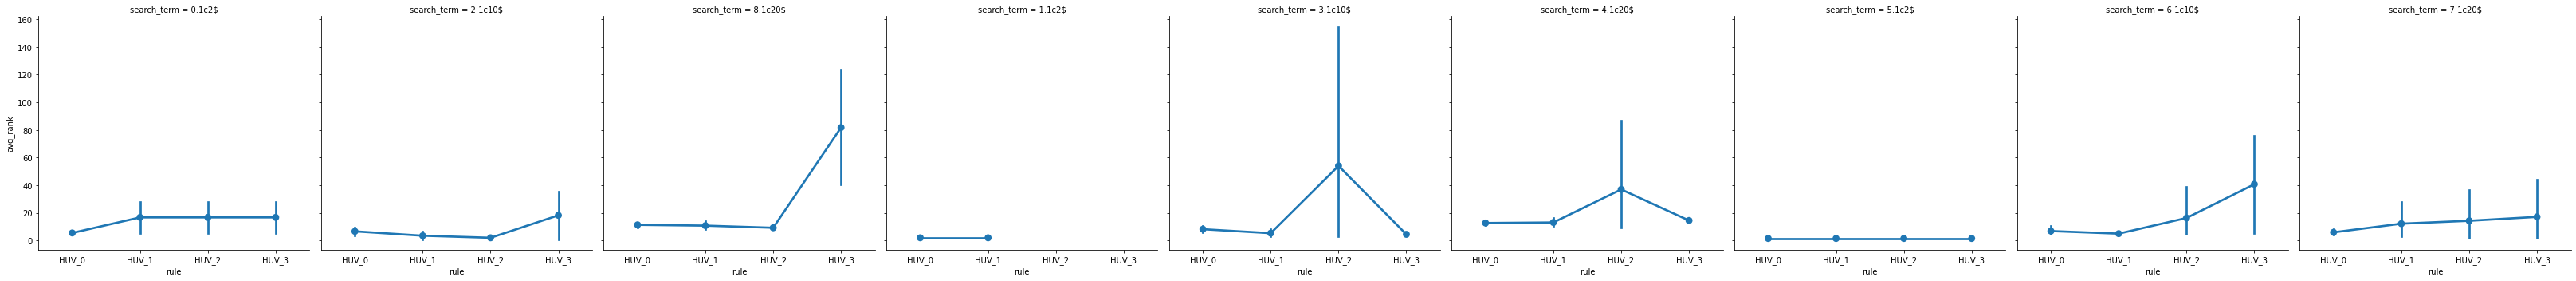

In [15]:
df = db.query(f"""
select *
from winners w inner join p2p_ranks r on w.search_product_id=r.id1 and w.product_id=id2
""")
# display(df[:30])
sns.catplot(data=df, kind='point', x='rule', y='avg_rank', col='search_term', ci=95, dodge=0.2)

### Manipulate


In [16]:
# delete the results
# db.exec(f"delete from winners where search_term like '%Generations%'")
# db.commit()

# Experiment: Distance graph using NetworkX

## Visualise the elections

laying out: iterations #2000
Showing graph limited to winners for: '%0_1c2' with id=244
Showing graph limited to winners for: '%2_1c10' with id=318
Showing graph limited to winners for: '%8_1c20' with id=414
Showing graph limited to winners for: '%1_1c2' with id=245
Showing graph limited to winners for: '%3_1c10' with id=319
Showing graph limited to winners for: '%4_1c20' with id=410
Showing graph limited to winners for: '%5_1c2' with id=249
Showing graph limited to winners for: '%6_1c10' with id=322
Showing graph limited to winners for: '%7_1c20' with id=413
CPU times: user 6.71 s, sys: 198 ms, total: 6.91 s
Wall time: 6.52 s


<Figure size 432x288 with 0 Axes>

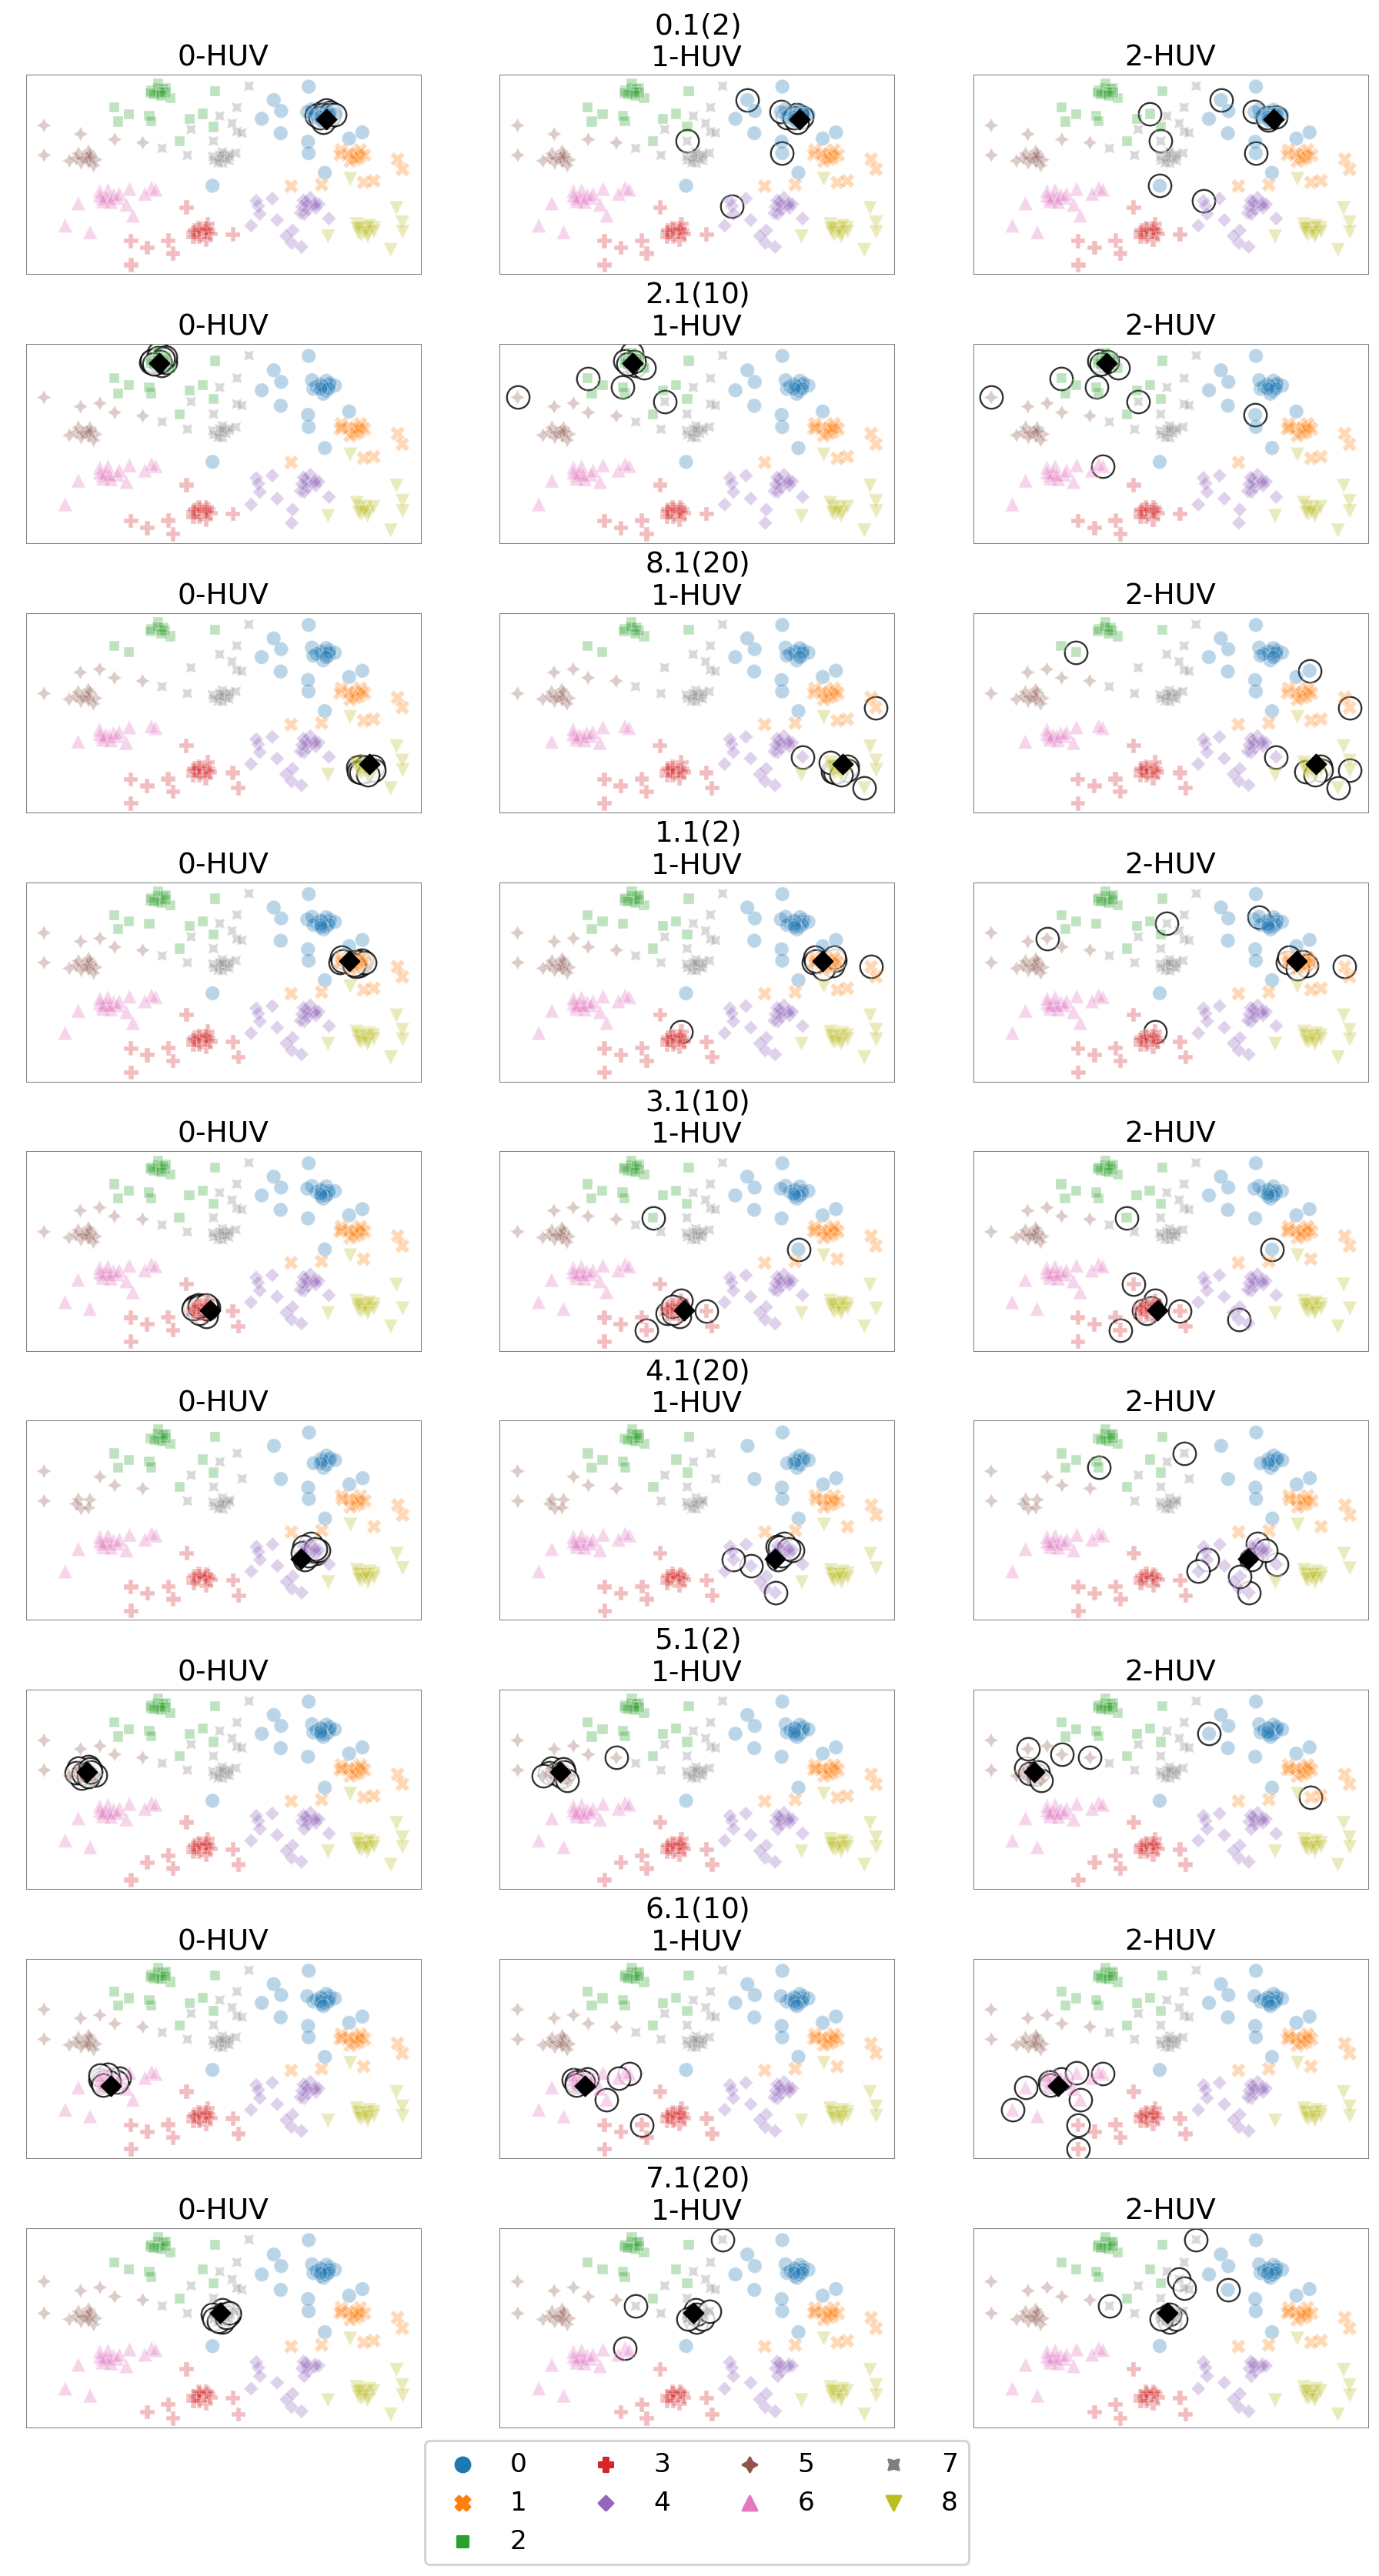

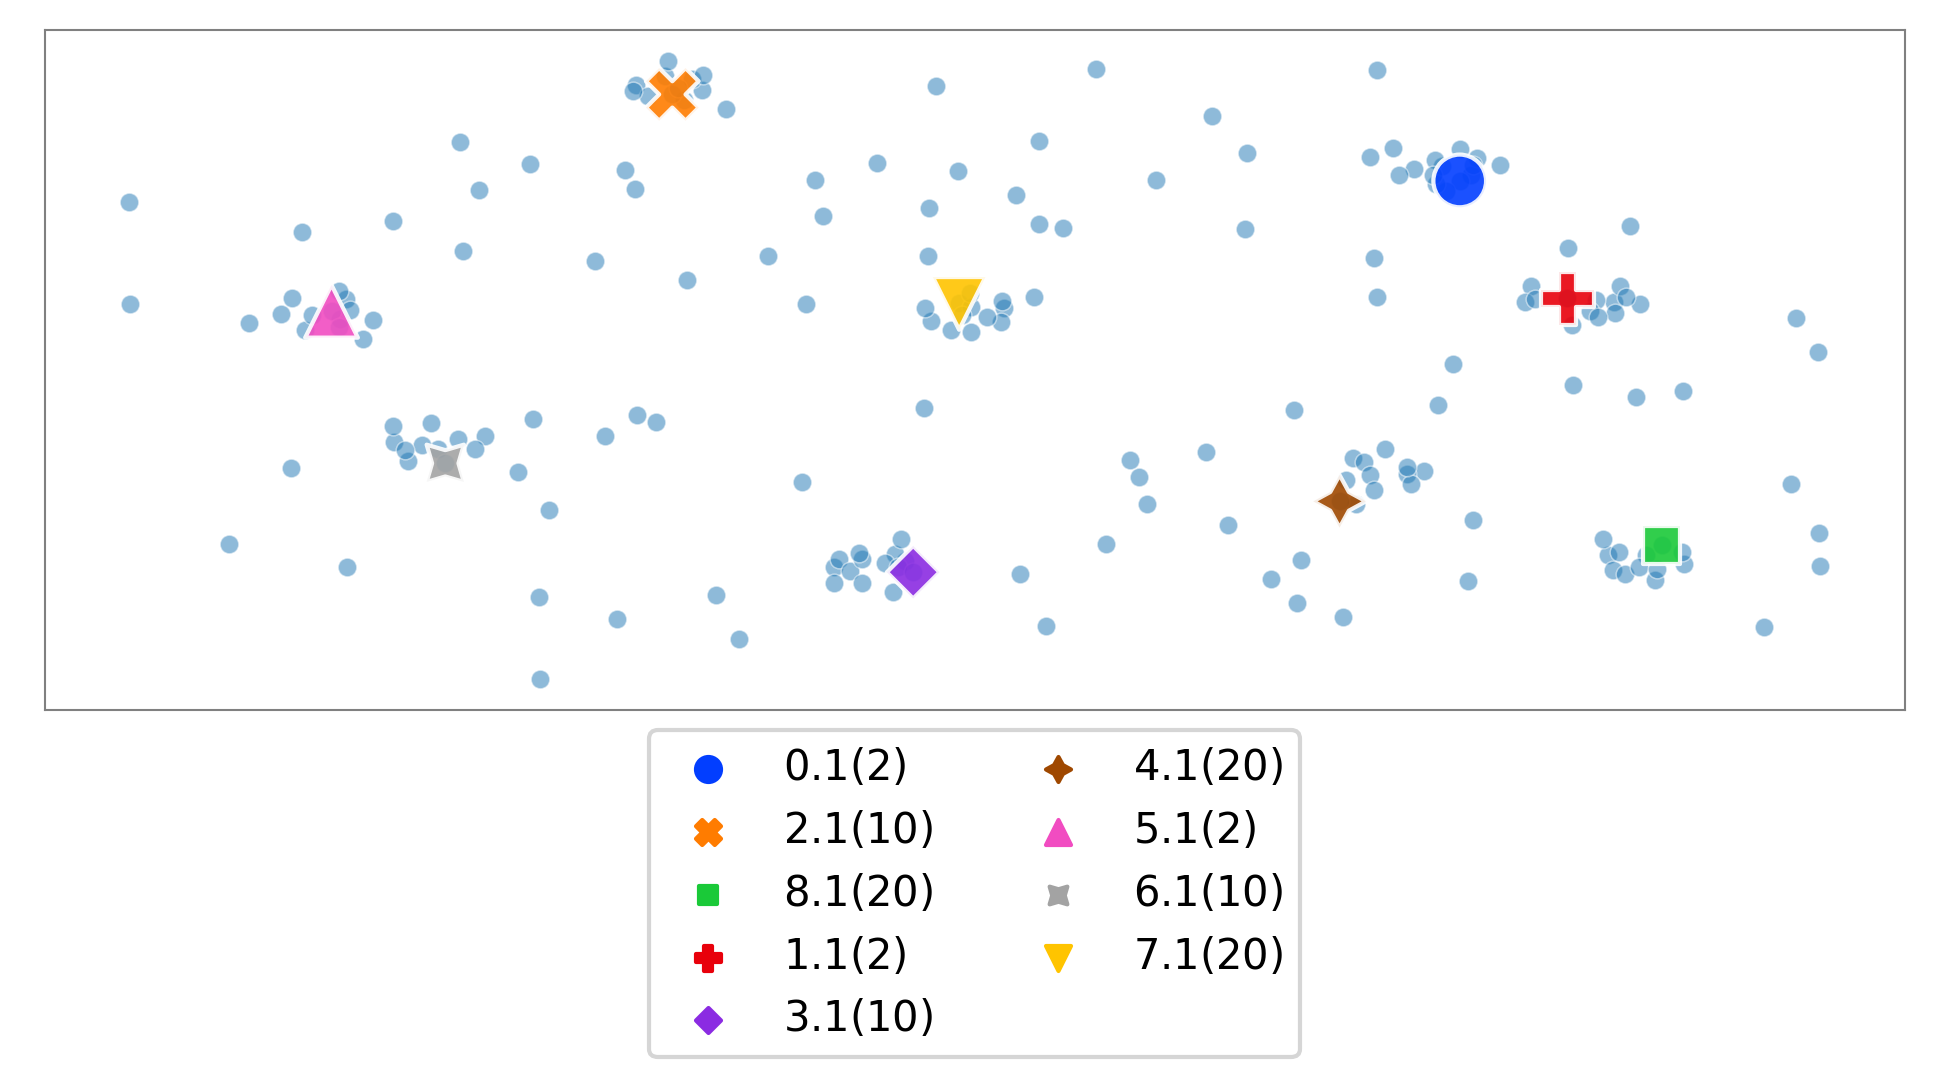

In [24]:
%%time
all_titles = PARAMS.searchterms
distance_utils.show_distances_layouts(
    graph_iterations,
    dist2force_funcs,
    db,
    all_titles,
    out_folder,
    dist_code,
    top_rank_count,
    seed=layout_seed
)

## Save outputs

In [18]:
winners = db.query(f"select w.*, p.main_genre from winners w join product p on w.product_id = p.product_id where w.search_term like '%%'  order by w.search_term, w.rule, w.rank")
winners.to_csv(f"{out_folder}/winners.csv", index=False)